TODO:
1. Run RandomForestRegressor along with linear_models
2. inference

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import joblib

In [2]:
df_raw = pd.read_parquet("AvailabilityDataCombined.gzip")

In [3]:
df = df_raw.loc[df_raw["last_update"] > pd.to_datetime("2024-02-15 09:40:00")]

In [4]:
featuresList = ["number","last_update","available_bikes","banking","temp","feels_like","pressure","humidity","uvi","clouds","visibility","wind_speed","wind_deg","wind_gust","weather_main","rain","weather_description"]
df = df[featuresList]

In [5]:
X = df.drop(['available_bikes'], axis=1)
y = df['available_bikes']

def addHourDayMonth(dfX):
    # Convert 'last_update' to datetime and extract useful features
    dfX['last_update'] = pd.to_datetime(dfX['last_update'])
    dfX['hour'] = dfX['last_update'].dt.hour
    dfX['day'] = dfX['last_update'].dt.day
    dfX['month'] = dfX['last_update'].dt.month
    dfX = dfX.drop(['last_update'], axis=1,inplace=True)
    
addHourDayMonth(X)

# Handling categorical variables and missing values
categorical_features = ["number",'weather_main', 'weather_description',"banking"]
numerical_features = X.drop(columns=categorical_features).columns

numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ])

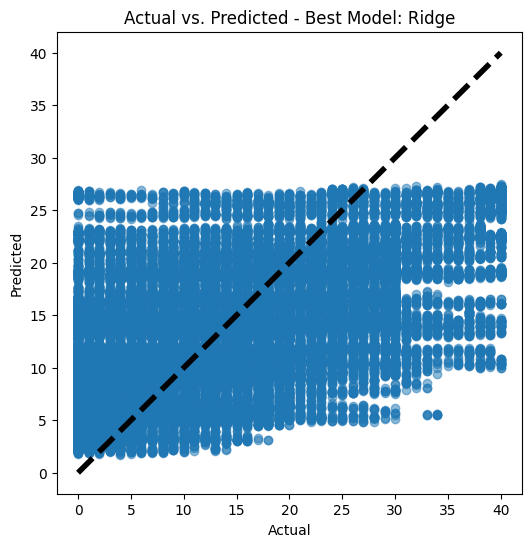

In [6]:
models = {
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'Linear Regression': LinearRegression(),
    # "RandomForestRegressor": RandomForestRegressor()
}

model_pipelines = {}
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    model_pipelines[name] = pipeline

# Evaluate each model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_scores = {}
for name, pipeline in model_pipelines.items():
    # Using negative MSE to make it easier to compare (higher is better)
    scores = cross_val_score(pipeline, X_train, y_train, scoring='neg_mean_squared_error', cv=3)
    model_scores[name] = scores.mean()

best_model_name = max(model_scores, key=model_scores.get)
best_pipeline = model_pipelines[best_model_name]

# Fit and predict using the best model
best_pipeline.fit(X_train, y_train)
y_pred = best_pipeline.predict(X_test)

# Visualization
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Actual vs. Predicted - Best Model: {best_model_name}')
plt.show()

In [7]:
#joblib.dump(best_pipeline, 'BestModel.joblib') 

['BestModel.joblib']

Inference:

In [72]:
from datetime import datetime
import requests
import json

OpenWeather_api_key = "6ac1c4119c9a1919193d6b37a98a9b0b"

In [73]:
dtForecast = int(datetime.strptime("2024-03-08 20:12:38", "%Y-%m-%d %H:%M:%S").timestamp())

In [74]:
weatherResponse = requests.get(f"https://api.openweathermap.org/data/3.0/onecall/timemachine?lat={53}&lon={-6}&dt={dtForecast}&appid={OpenWeather_api_key}")

In [75]:
def parse_item(item):
    rain = item.get('rain', {'1h': None}).get('1h')
    snow = item.get('snow', {'1h': None}).get('1h')
    weather_main = item['weather'][0]['main'] if 'weather' in item and item['weather'] else None
    weather_description = item['weather'][0]['description'] if 'weather' in item and item['weather'] else None
    return {
        'dt': item.get('dt'),
        'sunrise': item.get('sunrise'),
        'sunset': item.get('sunset'),
        'temp': item.get('temp'),
        'feels_like': item.get('feels_like'),
        'pressure': item.get('pressure'),
        'humidity': item.get('humidity'),
        'uvi': item.get('uvi'),
        'clouds': item.get('clouds'),
        'visibility': item.get('visibility'),
        'wind_speed': item.get('wind_speed'),
        'wind_deg': item.get('wind_deg'),
        'wind_gust': item.get('wind_gust'),
        'weather_main': weather_main,
        'weather_description': weather_description,
        'rain': rain,
        'snow': snow
    }

weatherJson = json.loads(weatherResponse.text)
weather = parse_item(weatherJson['data'][0])

In [85]:
station = {"number":1, "last_update":pd.to_datetime(dtForecast,unit='s'),"banking":0}
X_infer = pd.DataFrame.from_dict([station|weather])

In [86]:
filtered_features = [feature for feature in featuresList if feature in X_infer.columns]
X_infer = X_infer[filtered_features]
X_infer

,number,last_update,banking,temp,feels_like,pressure,humidity,uvi,clouds,visibility,wind_speed,wind_deg,wind_gust,weather_main,rain,weather_description
0,1,2024-03-08 20:12:38,0,280.68,276.29,1003,75,0,95,10000,9.19,88,12.31,Clouds,None,overcast clouds


In [87]:
addHourDayMonth(X_infer)

In [88]:
X_infer

,number,banking,temp,feels_like,pressure,humidity,uvi,clouds,visibility,wind_speed,wind_deg,wind_gust,weather_main,rain,weather_description,hour,day,month
0,1,0,280.68,276.29,1003,75,0,95,10000,9.19,88,12.31,Clouds,None,overcast clouds,20,8,3


In [89]:
bestModel = joblib.load('BestModel.joblib')
inferPipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', bestModel)
    ])
inferPipe.predict(X_infer)

ValueError: X has 141 features, but ColumnTransformer is expecting 18 features as input.